Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

import tensorflow_model_optimization as tfmot # Libraries to perform multiple model optimizations

Applying Clustering

In [2]:
PATH= "C:/Users/User/Downloads/Lab3/MobileNet-samples"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset_init = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset_init = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset_init.class_names

print(class_names)
val_batches = tf.data.experimental.cardinality(validation_dataset_init)
test_dataset = validation_dataset_init.take(val_batches // 5)
validation_dataset = validation_dataset_init.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat', 'cat']
Number of validation batches: 26
Number of test batches: 6


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset_init.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

(32, 7, 7, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [4]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
initial_epochs = 20
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()   

(32, 1280)
(32, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                          

In [5]:
# Initial Training

history = model.fit(train_dataset,validation_data=validation_dataset,
                    epochs=initial_epochs)

Epoch 1/30
94/94 [==============================] - 96s 978ms/step - loss: 0.6179 - accuracy: 0.6487 - val_loss: 0.4137 - val_accuracy: 0.8626
Epoch 2/30
94/94 [==============================] - 90s 958ms/step - loss: 0.3751 - accuracy: 0.8420 - val_loss: 0.2890 - val_accuracy: 0.9455
Epoch 3/30
94/94 [==============================] - 84s 895ms/step - loss: 0.2691 - accuracy: 0.9097 - val_loss: 0.2202 - val_accuracy: 0.9629
Epoch 4/30
94/94 [==============================] - 83s 887ms/step - loss: 0.2084 - accuracy: 0.9347 - val_loss: 0.1987 - val_accuracy: 0.9666
Epoch 5/30
94/94 [==============================] - 84s 889ms/step - loss: 0.1772 - accuracy: 0.9483 - val_loss: 0.1704 - val_accuracy: 0.9678
Epoch 6/30
94/94 [==============================] - 84s 890ms/step - loss: 0.1520 - accuracy: 0.9560 - val_loss: 0.1500 - val_accuracy: 0.9765
Epoch 7/30
94/94 [==============================] - 83s 887ms/step - loss: 0.1379 - accuracy: 0.9617 - val_loss: 0.1429 - val_accuracy: 0.9715

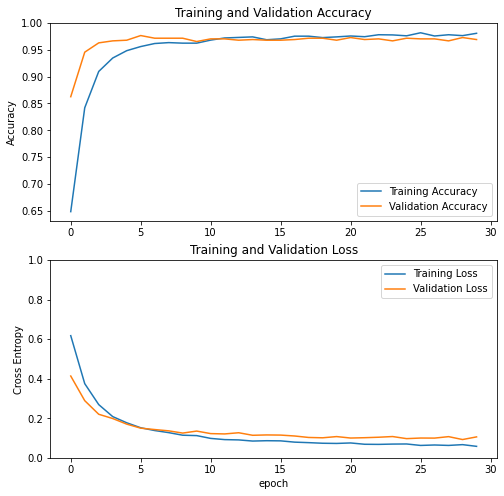

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()   

Fine Tuning

In [7]:
model.save('checkpoint_1.h5')

In [8]:
# #load model

# model = tf.keras.models.load_model('checkpoint_1.h5')
# model.summary()

In [56]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [57]:
# Pruning
num_images = 3000
end_step = np.ceil(num_images/BATCH_SIZE).astype(np.int32) * 20

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                           end_step=end_step)}

def apply_pruning(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)
    if isinstance(layer, tf.keras.layers.Dropout):
        return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)
    return layer

model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning
)
model_for_pruning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [58]:
len(model_for_pruning.trainable_variables)

2

In [60]:
fine_tune_pruned_epochs = 20
total_epochs =  initial_epochs + fine_tune_pruned_epochs

history_fine = model_for_pruning.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/50
94/94 [==============================] - 89s 948ms/step - loss: 0.0601 - accuracy: 0.9797 - val_loss: 0.1015 - val_accuracy: 0.9691
Epoch 31/50
94/94 [==============================] - 99s 1s/step - loss: 0.0715 - accuracy: 0.9770 - val_loss: 0.1065 - val_accuracy: 0.9678
Epoch 32/50
94/94 [==============================] - 126s 1s/step - loss: 0.0666 - accuracy: 0.9797 - val_loss: 0.1125 - val_accuracy: 0.9691
Epoch 33/50
94/94 [==============================] - 139s 1s/step - loss: 0.0712 - accuracy: 0.9747 - val_loss: 0.1109 - val_accuracy: 0.9678
Epoch 34/50
94/94 [==============================] - 140s 1s/step - loss: 0.0688 - accuracy: 0.9787 - val_loss: 0.1091 - val_accuracy: 0.9715
Epoch 35/50
94/94 [==============================] - 140s 1s/step - loss: 0.0762 - accuracy: 0.9740 - val_loss: 0.1101 - val_accuracy: 0.9703
Epoch 36/50
94/94 [==============================] - 140s 1s/step - loss: 0.0783 - accuracy: 0.9743 - val_loss: 0.1118 - val_accuracy: 0.9715
Epoch

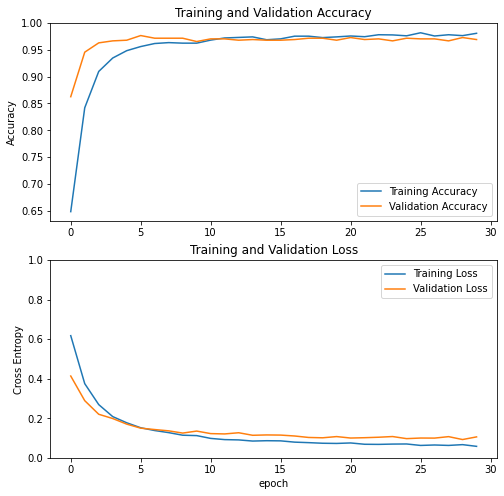

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()   

In [62]:
loss, accuracy = model_for_pruning.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 7s 1s/step - loss: 0.1262 - accuracy: 0.9635
Test accuracy : 0.9635416865348816


In [63]:
model_p = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [64]:
# Clustering

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

def apply_pruning(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return cluster_weights(layer,**clustering_params)
    if isinstance(layer, tf.keras.layers.Dropout):
        return cluster_weights(layer,**clustering_params)
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        return cluster_weights(layer,**clustering_params)
    return layer

model_for_clustering = tf.keras.models.clone_model(
    model_p,
    clone_function=apply_pruning
)
model_for_clustering.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_clustering.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [71]:
fine_tune_clustering_epochs = 20
total_epochs =  initial_epochs + fine_tune_pruned_epochs + fine_tune_clustering_epochs

history_fine = model_for_clustering.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=49,
                         validation_data=validation_dataset)

Epoch 50/70
94/94 [==============================] - 97s 1s/step - loss: 0.0798 - accuracy: 0.9800 - val_loss: 0.1230 - val_accuracy: 0.9715
Epoch 51/70
94/94 [==============================] - 96s 1s/step - loss: 0.0814 - accuracy: 0.9747 - val_loss: 0.1226 - val_accuracy: 0.9715
Epoch 52/70
94/94 [==============================] - 97s 1s/step - loss: 0.0798 - accuracy: 0.9757 - val_loss: 0.1233 - val_accuracy: 0.9703
Epoch 53/70
94/94 [==============================] - 113s 1s/step - loss: 0.0808 - accuracy: 0.9773 - val_loss: 0.1261 - val_accuracy: 0.9678
Epoch 54/70
94/94 [==============================] - 133s 1s/step - loss: 0.0805 - accuracy: 0.9750 - val_loss: 0.1249 - val_accuracy: 0.9703
Epoch 55/70
94/94 [==============================] - 143s 2s/step - loss: 0.0853 - accuracy: 0.9747 - val_loss: 0.1234 - val_accuracy: 0.9678
Epoch 56/70
94/94 [==============================] - 150s 2s/step - loss: 0.0782 - accuracy: 0.9780 - val_loss: 0.1147 - val_accuracy: 0.9740
Epoch 57/

Predictions:
 [1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0]
Labels:
 [1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0]


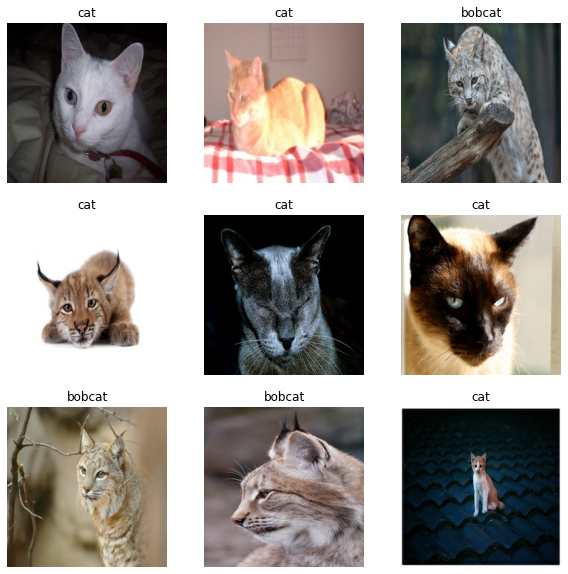

In [73]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_for_clustering.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [74]:
loss, accuracy = model_for_clustering.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 7s 1s/step - loss: 0.0858 - accuracy: 0.9688
Test accuracy : 0.96875


In [75]:
final_model = tfmot.clustering.keras.strip_clustering(model_for_clustering)
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Quantization starts here
converter.target_spec.supported_types = [tf.float16] # 50% Size Reduction
tflite_model = converter.convert()

# Save the model.
with open('model(final).tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp8glrcm_k\assets
